In [51]:
import numpy as np 
import pandas as pd
import seaborn as sns
sns.reset_defaults
sns.set_style(style='darkgrid')
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest
plt.style.use('ggplot')
font = {'size'   : 16}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
%matplotlib inline

In [52]:
from campaign_performance import qty_by_feature, pct_by_feature

In [53]:
df = pd.read_csv('data/joined_data.csv')

In [54]:
df.sample(10)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
15729,608196,long_email,generic,6,Wednesday,US,4,0.0,0.0
36510,810344,long_email,personalized,14,Sunday,US,2,1.0,0.0
56685,971423,long_email,generic,10,Monday,US,2,0.0,0.0
52072,539662,long_email,personalized,15,Saturday,US,0,0.0,0.0
44632,20288,short_email,generic,7,Wednesday,US,0,0.0,0.0
60907,284274,short_email,personalized,6,Tuesday,US,2,0.0,0.0
58299,903781,short_email,generic,3,Sunday,US,5,0.0,0.0
91957,69562,short_email,generic,14,Saturday,UK,2,0.0,0.0
13348,880661,long_email,personalized,8,Thursday,UK,3,0.0,0.0
4139,758097,short_email,generic,12,Sunday,ES,1,0.0,0.0


## Results of Email Campaign
Percentage of people who opened the email: 10.345%  
Percentage of people who clicked on the email: 2.119%

### Observations of Data

Caveat: these are initial obervations based on the data. Proper testing would be required to determine if these distinctions fall outside of the range of expected variance.

* US and UK users clicked at much higher rate. Consider if French and Spanish translations need to be improved.

* Shorter and more personalized emails led to higher CTRs.

* Users with greater past purchases tended to click more.

* Friday Saturday, and Sunday appear to be worst days to send the email.

## Numbers of Email Recipients / Recipients who Clicked

In [55]:
cols = ['email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'user_past_purchases']

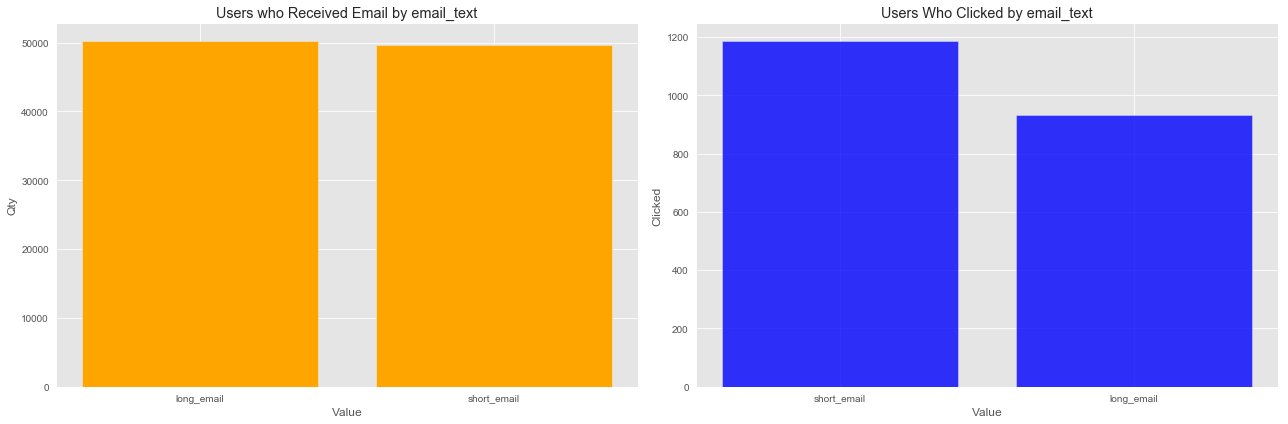

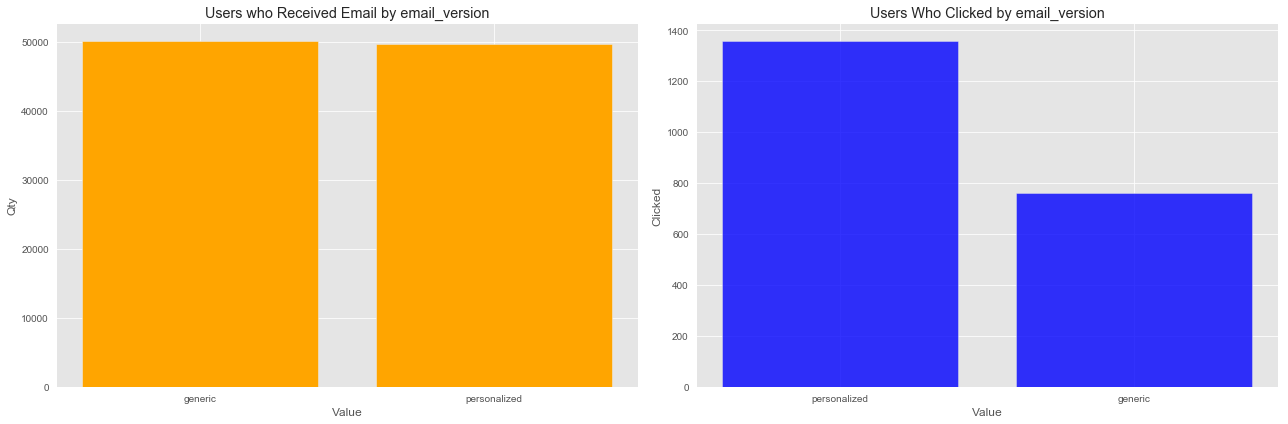

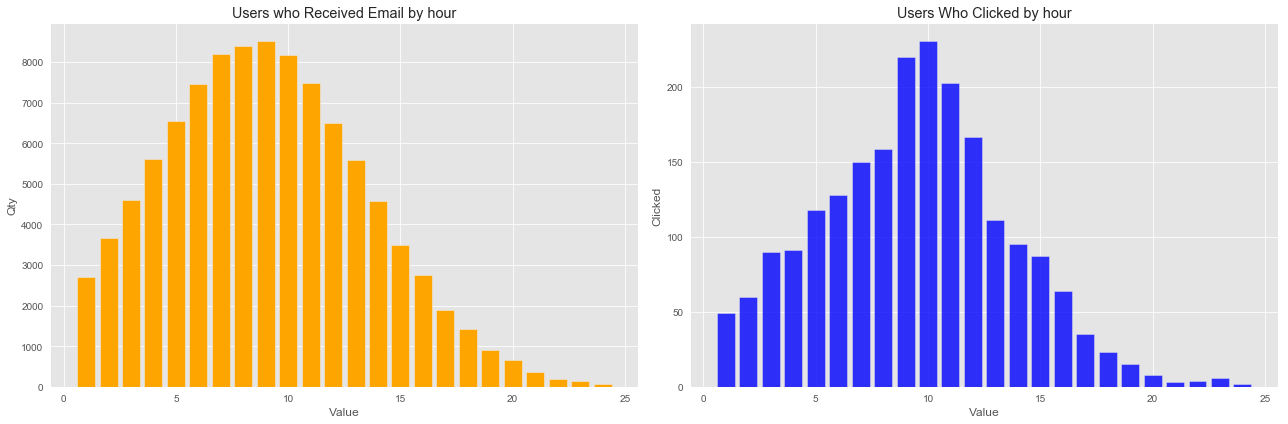

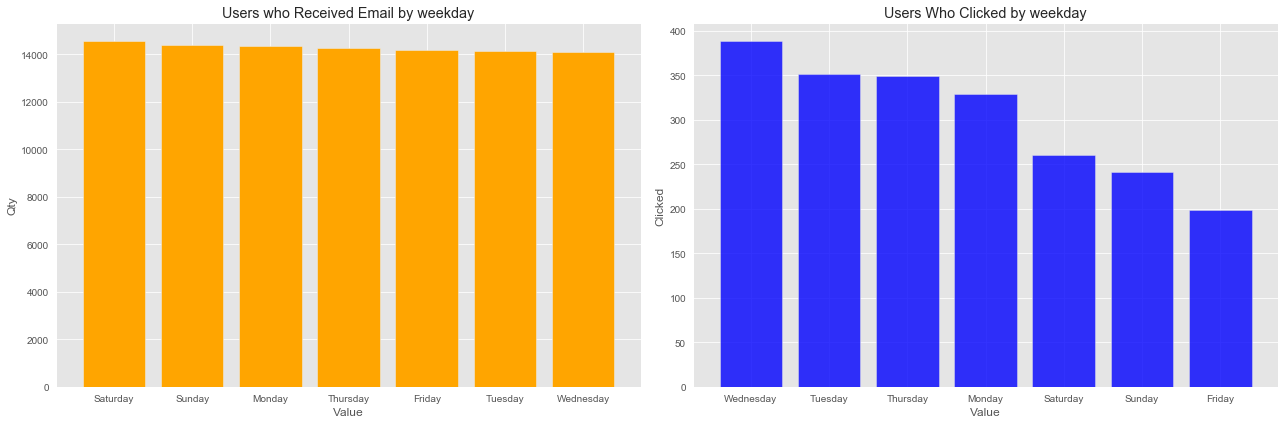

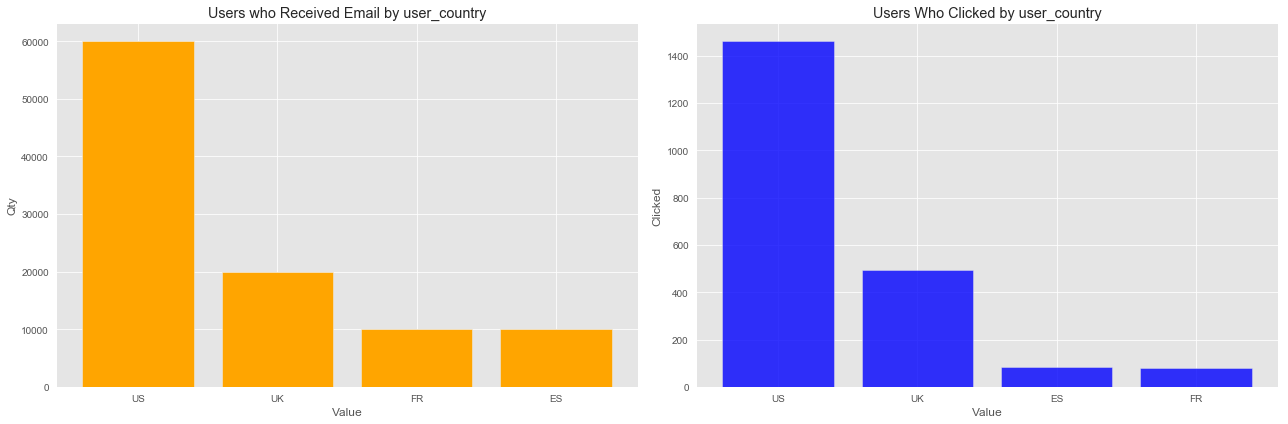

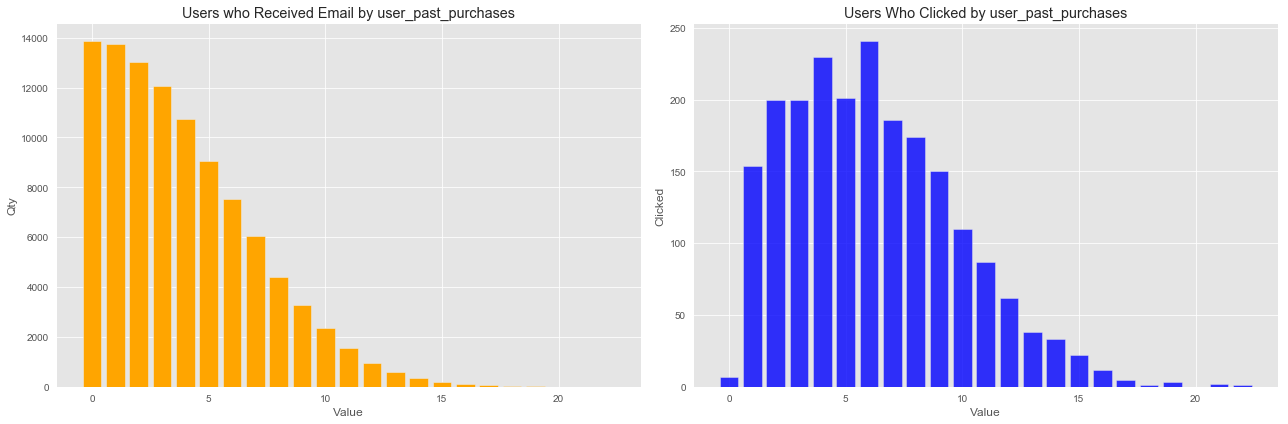

In [56]:
qty_by_feature(df, cols)

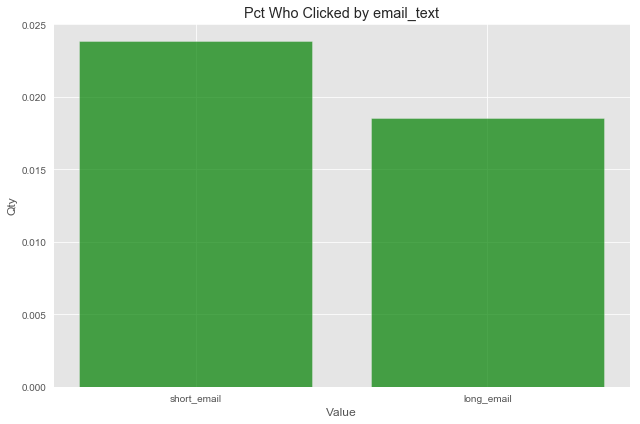

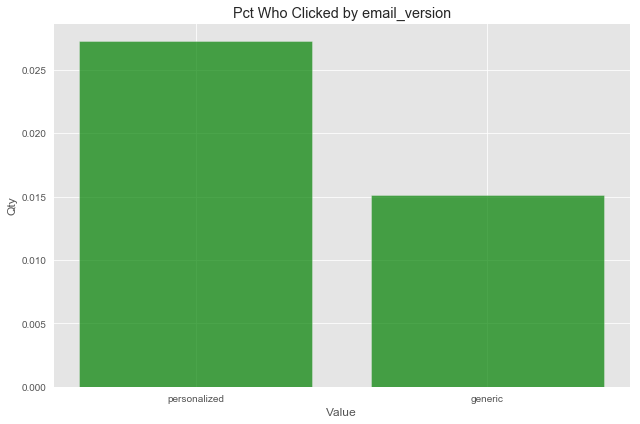

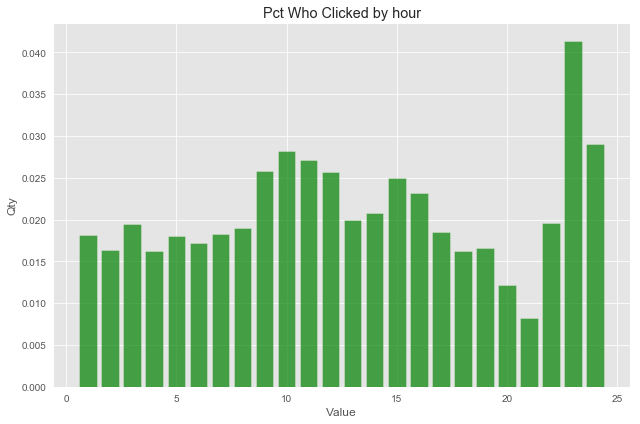

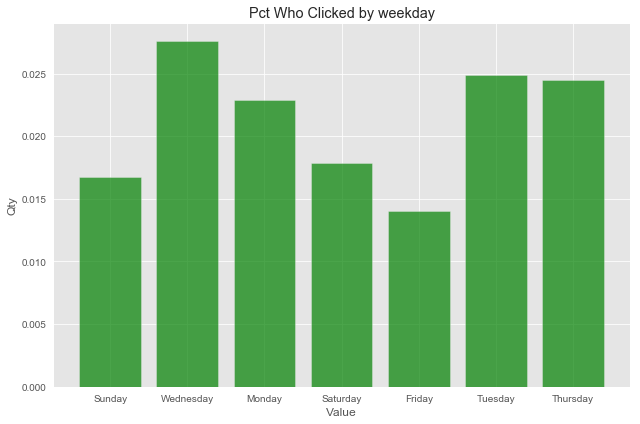

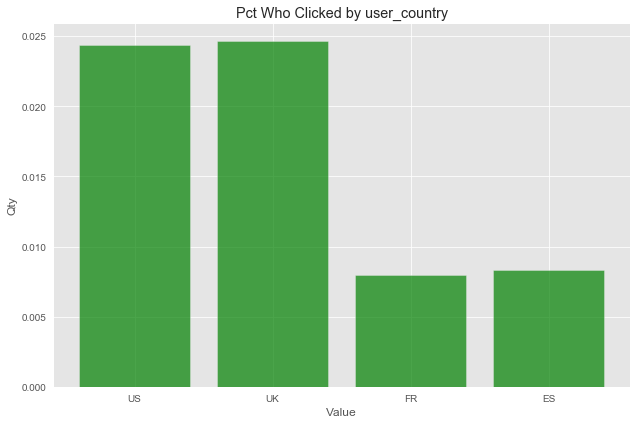

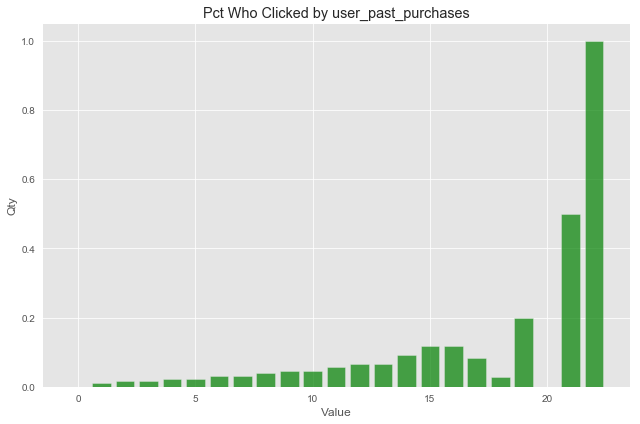

In [57]:
pct_by_feature(df, cols)

## Modeling
A baseline model is simply randomly selecting users to email, or emailing all users. This will provide a CTR of ~ 2.119%

Which is more important: the click-through rate, or the raw of number of click-throughs? Assuming that the cost of sending a marketing email is close to zero, it may be best to simply send the email to all users. If on the other hand there is significant cost to sending an email to customer who will not click, the a profit analysis needs to be performed to identify the optimum model prediction threshold. 

## Recommendations

Send the email to all users, but optimize for email characteristics that make it more likely that the user will click.

In [58]:
# Perform a series of t-test to determine if differences are statistically signficant or just due to random error

## Due to the p_values below, the differences in the CTR for email text and email version are statistically sigificant.

In [59]:
    cols = ['email_text', 'email_version']
    for column in cols:
        counts = []
        obs = []
        for item in df[column].unique():
            counts.append(df[df[column] == item]['clicked'].sum())
            obs.append(df[df[column] == item].shape[0])
        stat, pval = proportions_ztest(counts, obs)
        print(column, pval)

email_text 4.738094975953786e-09
email_version 1.2295132171191242e-40


## Chi-Squared Test for Goodness of Fit to Uniform Distibution: Due to the p_values, none of the variables fit a uniform distribution.  
## Translation: all of the observed differences are statistically significant

In [60]:
    multi_cols = ["user_country", "hour", "weekday", "user_past_purchases"]
    ctr = df["clicked"].sum() / df.shape[0] 
    for column in multi_cols:
        exp = []
        obs = []
        for item in df[column].unique():
            exp.append(df[df[column] == item].shape[0] * ctr)
            obs.append(df[df[column] == item]["clicked"].sum())
        chisq, p = chisquare(obs, exp, ddof=(len(df[column].unique()) - 1))
        print("{}: Chi Sq Stat {}, P_value {}".format(column, chisq, p))

user_country: Chi Sq Stat 199.758150229475, P_value nan
hour: Chi Sq Stat 87.9775687710944, P_value nan
weekday: Chi Sq Stat 101.04320606345784, P_value nan
user_past_purchases: Chi Sq Stat 1244.2272467789992, P_value nan


## Optimal Email Characteristics

In [61]:
opt_df = df[(df['email_text'] == "short_email") & (df['email_version'] == "personalized")]

In [62]:
opt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24751 entries, 0 to 99995
Data columns (total 9 columns):
email_id               24751 non-null int64
email_text             24751 non-null object
email_version          24751 non-null object
hour                   24751 non-null int64
weekday                24751 non-null object
user_country           24751 non-null object
user_past_purchases    24751 non-null int64
opened                 24751 non-null float64
clicked                24751 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 1.9+ MB


In [63]:
op_df = opt_df[(opt_df['weekday'] == "Monday") | (opt_df['weekday'] == "Tuesday") | (opt_df['weekday'] == "Wednesday") | (opt_df['weekday'] == "Thursday")]

In [66]:
print("CTR with optimized email features: {}".format(op_df["clicked"].sum() / op_df.shape[0]))

CTR with optimized email features: 0.03484098939929329


In [67]:
top_2 = op_df[(op_df['user_country'] == "UK") | (op_df['user_country'] == "US")]
print("CTR with optimized email features in US and UK: {}".format(top_2["clicked"].sum() / top_2.shape[0]))

CTR with optimized email features in US and UK: 0.03967761934283943


# Conclusion

Short, personalized emails sent M-TH have a CTR of ~3.48 percent, more than the overall CTR of ~2.12%. 

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, roc_curve, recall_score, classification_report
from imblearn.over_sampling import SMOTE

In [15]:
dt = DecisionTreeClassifier()

In [16]:
from model import Dummify

In [38]:
X = df.drop(["opened", "clicked", "user_country"], axis=1)
y = df["user_country"]

# define columns for one-hot encoding and merging back
drop_cols = ['email_text', 'email_version', 'weekday']
merge_cols = ['email_id', 'hour', 'user_past_purchases']

# dummify
d = Dummify(X, drop_cols, merge_cols)
d.get()
X = d.swap()

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,   random_state=42)

# smote
cols = X_train.columns
sm = SMOTE(random_state=66) # oversample minority class
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(data=X_train, columns=list(cols)) # return to dataframe


In [39]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
predictions = dt.predict(X_test)

In [41]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

         ES       0.10      0.14      0.12      3352
         FR       0.11      0.15      0.12      3299
         UK       0.20      0.22      0.21      6657
         US       0.60      0.50      0.54     19692

avg / total       0.42      0.37      0.39     33000

